# Laboratorio 6
#### 20880 Sebastian Aristondo
#### 20293 Daniel Gonzalez

## Ejercicio 1

Cree un programa en Python (o en el lenguaje de su preferencia) para modelar la distribución de temperatura dentro
de una varilla sólida. Utilice modelado secuencial multiescala, donde combina un modelo macroscópico y un
modelo microscópico. Suponga que la varilla consta de dos materiales diferentes con diferentes conductividades
térmicas.

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [7]:
class atomo(object):
    
    def __init__(self, masa, left_neighbour, right_neighbour, position):
        self.move= ["left", "right"]
        self.mass = masa
        self.left_neighbour = left_neighbour
        self.right_neighbour = right_neighbour
        self.position = position

    def random_move(self):
        self.position = random.choice(self.move)
    
    def exist_colision(self):
        if self.left_neighbour:
            if self.left_neighbour.position == "right" and self.position == "left":
                return (self.left_neighbour.mass + self.mass)*0.5
        if self.right_neighbour:  
            if self.right_neighbour.position == "left" and self.position == "right":
                return (self.right_neighbour.mass + self.mass)*0.5
        
        return 0


In [8]:
masa_aluminio = 2700
masa_hierro = 7850
tipo_atomo = [masa_aluminio, masa_hierro]
c = (masa_hierro * 450 + masa_aluminio * 900) / (masa_aluminio + masa_hierro)
T = 280
iteraciones_micro = 1000
atomos = 1000
epochs = 20

In [9]:
# Definir el rango deseado para velocidades más frecuentes
velocidad_minima = 0.5
velocidad_maxima = 1.5

# Calcular la media en ese rango
media_en_rango = (velocidad_maxima + velocidad_minima) / 2

# Calcular la tasa (lambda) para la distribución exponencial
lambda_param = 1 / media_en_rango

# Tamaño de la muestra
tamaño_muestra = epochs * iteraciones_micro

# Generar una muestra de velocidades con distribución exponencial
muestras_exponencial = np.random.exponential(scale=1/lambda_param, size=tamaño_muestra)

In [10]:
varilla=[]
m = 0
for i in range(atomos):
    if i % 2 ==0:
        varilla.append(atomo(masa_aluminio, None, None, i))
        m += masa_aluminio
    else:
        varilla.append(atomo(masa_hierro, None, None, i))
        m += masa_hierro
        
for i in range(atomos):
    if i == 0:
        varilla[i].right_neighbour = varilla[i+1]
    elif i == atomos-1:
        varilla[i].left_neighbour = varilla[i-1]
    else:
        varilla[i].left_neighbour = varilla[i-1]
        varilla[i].right_neighbour = varilla[i+1]
    

In [11]:
def calculate_Q(res, velocity):
    return res * velocity

In [12]:
def temperature_differnce(Q):
    return Q / (m * c)

In [13]:
i = 0
temperatura = []
Q = []
for epoch in range(epochs):
    Q_acumulado = 0
    for iteraciones in range(iteraciones_micro):
        velocidad = muestras_exponencial[i]
        i += 1
        for atomo in varilla:
            atomo.random_move()
        for atomo in varilla:
            Q_acumulado += calculate_Q(atomo.exist_colision(), velocidad)
    Q_acumulado /= 2.0
    Q_promedio = Q_acumulado / iteraciones_micro
    T = T + temperature_differnce(Q_promedio)
    Q.append(Q_promedio)
    temperatura.append(T)


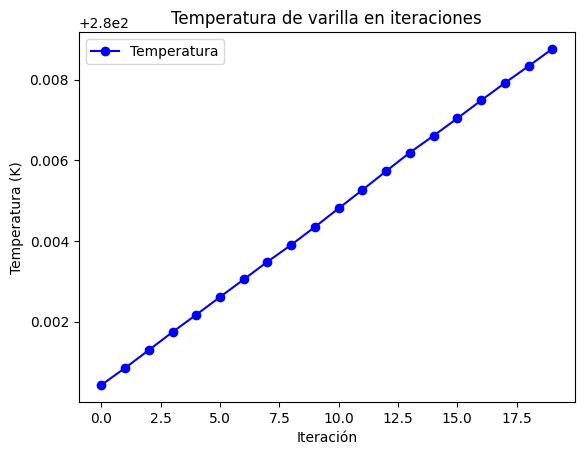

In [14]:
# Crear el gráfico con líneas que unen los puntos para 'temperatura'
plt.plot(range(len(temperatura)), temperatura, color='b', label='Temperatura', marker='o', linestyle='-')

# Añadir etiquetas y título
plt.xlabel('Iteración')
plt.ylabel('Temperatura (K)')
plt.title('Temperatura de varilla en iteraciones')

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

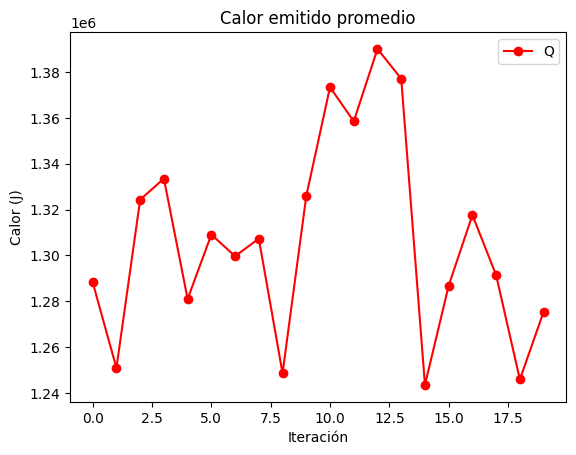

In [15]:
# Crear el gráfico con líneas que unen los puntos para 'Q'
plt.plot(range(len(Q)), Q, color='r', label='Q', marker='o', linestyle='-')

# Añadir etiquetas y título
plt.xlabel('Iteración')
plt.ylabel('Calor (J)')
plt.title('Calor emitido promedio')

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

**a. ¿En qué se diferencia el modelo macroscópico del modelo microscópico en este escenario?**


El modelo macroscópico se basa en la temperatura de la varilla en general, mientras que el modelo microscópico se basa en la temperatura de los átomos que componen la varilla. También si diferencia en que el modelos microscópico se basa en agentes y el modelo macroscópico es una formula de energía cinética.

**b. ¿Cuáles son las condiciones de contorno del modelo microscópico y cómo las determina el modelo macroscópico?**


La condición del modelo microscópico se basa en si ocurre una colisión entre los átomos. Todos aquellos átomos que colisionen generar calor. El modelo macroscópico calculara la temperatura de la varilla en base a la suma de las temperaturas de los átomos.

**c. ¿Cómo adaptaría este modelo multiescala si la varilla estuviera compuesta por más de dos materiales diferentes?**


Debido a como realizamos nuestra implementación el modelo se adaptaría muy facil. Al momento de inicializar la calse atomo solo sería de establecer la masa de los n materiales nuevos. La simulación sería exactamente igual ya que solo se estaría afectando la masa de los átomos.

## Ejercicio 2

Implemente un enfoque de modelado multiescala concurrente en Python para simular el flujo de agua a través de
una formación rocosa porosa. Utilice tanto un modelo macroscópico (ley de Darcy) como un modelo microscópico
(ecuaciones de Navier-Stokes) para describir el flujo.

In [16]:
A = 1.25 # m^2
ro = 997 # kg/m^3
miu = 0.226 * 10 ** -6 # Visocidad cinemática 60 C
delta_P = 1000 # Pa

In [41]:
# Paso 1: Simulación del flujo con la Ley de Darcy (Macroescala)
def simulate_darcy_flow(velocidad_media = 0.5):
    k = (ro * velocidad_media * L) / delta_P
    return k*A*(delta_P / L), k


# Parámetros del problema
L = 1.0  # Longitud del dominio
Nx = 100  # Número de puntos de la malla espacial
dx = L / (Nx - 1)  # Tamaño de paso en la malla
nu = 0.226 * 10 ** -6  # Viscosidad cinemática
dt = 0.001  # Paso de tiempo
# Inicialización de la malla espacial
x = np.linspace(0, L, Nx)

# Inicialización de la condición inicial (perfil inicial de velocidad)
u = np.zeros(Nx)
u[int(0.5 / dx):int(0.6 / dx)] = 1.0  # Condición inicial: un pulso de velocidad


# Paso 2: Simulación del flujo con las Ecuaciones de Navier-Stokes (Microescala)
def simulate_navier_stokes_flow(macroscopic_results, u):
    u_new = np.zeros(Nx)
    for i in range(1, Nx - 1):
        # Implementación de la discretización de las ecuaciones de Navier-Stokes
        k_i = macroscopic_results
        u_new[i] = u[i] + k_i + nu * dt / dx**2 * (u[i+1] - 2 * u[i] + u[i-1])

    # Actualización del perfil de velocidad
    u = u_new
    return np.mean(u)


velocidad_result =[] 
velocidad_micro = []
# Paso 3: Enfoque Multiescala Concurrente
def multiscale_simulation():
    # Inicializa las simulaciones macro y micro
    macroscopic_results, k = simulate_darcy_flow()
    microscopic_results = simulate_navier_stokes_flow(k, u)
    
    # Itera o acopla las simulaciones según sea necesario
    for _ in range(num_iterations):
        # Realiza la simulación microscópica
        microscopic_results = simulate_navier_stokes_flow(k, u)
        # Realiza la simulación macroscópica
        macroscopic_results, k = simulate_darcy_flow(microscopic_results)
        velocidad_result.append(macroscopic_results)
        velocidad_micro.append(microscopic_results)
        # velocidad_result.extend(macroscopic_results)
    
    return velocidad_result

# Paso 4: Visualización del Flujo de Agua
def visualize_results(speed):
    plt.plot(speed)
    plt.show()

# Ejecuta la simulación multiescala y visualiza los resultados
num_iterations = 1000
vel = multiscale_simulation()

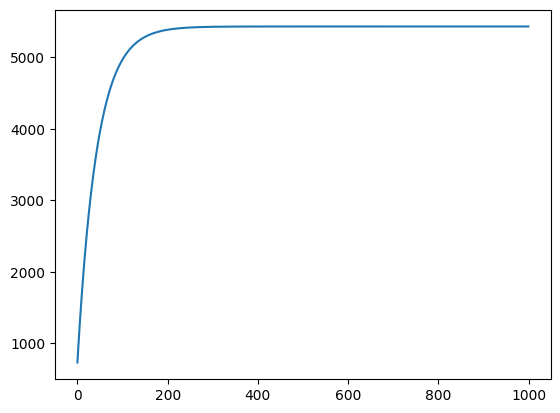

In [42]:
visualize_results(vel)

a. ¿En qué se diferencia el enfoque multiescala concurrente del enfoque multiescala secuencial?

La principal diferencia entre los dos enfoques es el paso de información entre las escalas. En un enfoque secuencial, primero se ejecuta cierta cantidad de iteraciones del modelo microscópico y luego la información recopilada se le pasa al modelo macroscópico. En el modelo concurrente, como se observa en esta simulación, se le pasa información de una escala a otra en cada iteración, sin tener que esperar a que corra una primero y luego la otra, es una actualización constante.


b. ¿Qué información del modelo macroscópico se pasa al modelo microscópico y cómo afecta a la
simulación microscópica?

La información que se le pasa del macroscópico al microscópico en este caso es la permeabilidad general de la roca, la cual, afecta las ecuaciones de navier stokes al momento de calcular la velocidad de los fluidos. Se pasa esta información, debido a que la permeabilidad de la roca no es uniforme, cambia con el tiempo y también con el paso del tiempo. Esto afecta la velocidad con la que pasa el agua microscópicamente, debido a que a una menor permeabilidad debe pasar menos agua, lo que se observa en el gráfico.


c. ¿Cuáles son las ventajas de utilizar modelado multiescala concurrente en este escenario?

En este escenario es crucial usar el modelado concurrente, debido a que permite obtener información en cada timestep de cómo está pasando el agua microscópicamente. Si se hiciera secuencial, solo se obtendría información de la velocidad promedio y no de cada iteración, lo cual no permitiría actualiza adecuadamente los valores macroscópicos, además de que no se podría modificar la permeabilidad en tiempo real microscópicamente. Entonces, al usar el modelo podemos tener una representación más realista y precisa del fenómeno.



## Ejercicio 3

Tiene la tarea de modelar el crecimiento de la población en múltiples escalas, desde organismos individuales hasta
la población global. Para esto debe implementar un modelo multiescala en Python para analizar el crecimiento
poblacional y su impacto.

In [18]:
class packet(object):
    
    def __init__(self, mens, womens,number):
        self.number = number
        self.mens = int(mens)
        self.womens = int(womens)
        self.childrens_probability = random.uniform(0.1, 1)

    def sex(self,sobrante):
        cantidad_hijos = int(min(sobrante,min(self.mens, self.womens))/4 * self.childrens_probability)
        proporcion = random.uniform(0.1, 1)
        self.mens += int(cantidad_hijos * proporcion)
        self.womens += int(cantidad_hijos * (1-proporcion))
        
        
    
    def consume_resources(self):
        return int(self.mens + self.womens)

    def starvation(self,deficit):
        deficit = int(deficit)
        
        for dead in range(deficit):
            if dead %2 == 0 and self.mens > 0:
                self.mens -= 1
            elif dead %2 != 0 and self.womens > 0:
                self.womens -= 1
                
    def get_population(self):
        return int(self.mens + self.womens)

In [19]:
class village(object):
    
    def __init__(self, resources):
        self.resources = int(resources)
        self.max_resources = int(resources)
        self.regenerate = 1+random.uniform(0.5, 0.9)

    def consume_resources(self, consumtion):
        self.resources -= consumtion
    
    def regenerate_resources(self):
        if self.resources < 100:
            self.resources += 123
        self.resources *= self.regenerate
        
        if self.resources > self.max_resources:
            self.resources = self.max_resources
            
        self.resources = int(self.resources)

    def get_resources(self):
        return self.resources

    
        

In [46]:
#SIMULACION DE POBLACIONES
random.seed(8)
cantidad_lugares = 5
lugares = []
poblaciones = []

for v in range(cantidad_lugares):
    lugares.append(village(random.uniform(1000, 2500)))
    if cantidad_lugares - 2 >v:
        poblaciones.append(packet(random.uniform(50, 70), random.uniform(50, 80), v))

dias_simulacion = 450

total_population = []
total_resources = []

acu_p = 0
acu_r = 0
for poblacion in poblaciones:
    acu_p += poblacion.get_population()
    
for lugar in lugares:
    acu_r += lugar.get_resources()
    
total_population.append(acu_p)
total_resources.append(acu_r)    


for dia in range(dias_simulacion):
    acu_p = 0
    acu_r = 0
    for poblacion in poblaciones:
        ubicacion = random.randint(0, cantidad_lugares-1)
        visited_ubicacion = lugares[ubicacion]
        resource_poblacion = poblacion.consume_resources()
        deficit = resource_poblacion - visited_ubicacion.get_resources()
        if deficit > 0:
            poblacion.starvation(deficit)
            visited_ubicacion.consume_resources(resource_poblacion-deficit)
        else:
            visited_ubicacion.consume_resources(resource_poblacion)
            poblacion.sex(abs(deficit))
        
        acu_p += poblacion.get_population()
        acu_r += visited_ubicacion.get_resources()
        
    total_population.append(acu_p)
    total_resources.append(acu_r)
    
    for lugar in lugares:
        lugar.regenerate_resources()
        
    

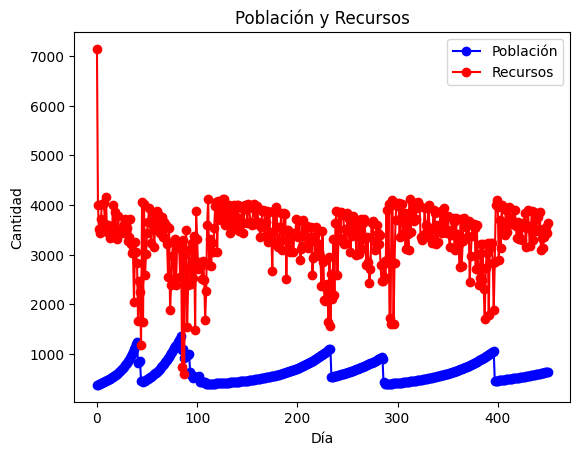

In [47]:

plt.plot(range(len(total_population)), total_population, color='b', label='Población', marker='o', linestyle='-')
plt.plot(range(len(total_resources)), total_resources, color='r', label='Recursos', marker='o', linestyle='-')

# Añadir etiquetas y título
plt.xlabel('Día')
plt.ylabel('Cantidad')
plt.title('Población y Recursos')
plt.legend()
plt.show()

**a. ¿Qué es el modelado multiescala y por qué es esencial para comprender sistemas complejos como el
crecimiento de la población?**

El modelado multiescala es una técnica utilizada en la ciencia y la ingeniería para comprender y representar sistemas complejos que operan en múltiples niveles de organización y con interacciones que ocurren a diferentes escalas espaciales y temporales. Es esencial para comprender sistemas complejos como el crecimiento de la población, ya que permite modelar el fenómeno a diferentes escalas, lo que permite obtener información más precisa y realista del fenómeno.

**b. Describe el modelo a nivel individual en esta simulación multiescala. ¿Qué factores se consideran a escala
individual?**
Los individuos (hombres o mujeres) consumen los recursos de los valles y si ven que hay suficientes recursos como para tener hijos, entonces se reproducen. Si no hay suficientes recursos, entonces no se reproducen. Los individuos también mueren de hambre si no hay suficientes recursos. Cada manda tiene una distribución uniforme sobre como se distribuieran los hijojs cuandos hombres y mujeres se tendrán en cada manada.

**c. Discuta el modelo a escala de comunidad local. ¿Cómo incorpora interacciones entre individuos y factores
ambientales?**
Los valles tienen una capacidad maxima de recursos, asi como también una taza de recuperación. Los individuos se mueven de forma aleatoria entre los valles buscando recursos. Por lo tanto si una manda se va dejando un valle sin recursos y luego llega una manada, esta manada se vera afectada perdiendo miembros por inanición.

**d. Explique el modelo a escala global. ¿Qué parámetros y factores se consideran al modelar toda la población
mundial?**

Toda la población se ve afectada por las acciones de las manadas, ya que si una manada se va de un valle dejándolo sin recursos, entonces la población mundial se ve afectada, ya que hay menos recursos para todos. Además, la población mundial se ve afectada por la cantidad de recursos que hay en cada valle, ya que si hay más recursos, entonces la población mundial crece más rápido, y si hay menos recursos, entonces la población mundial crece más lento. A su vez como los valles tienen una capacidad maxima de producción de recursos la población también tiene un limite de crecimiento si las condiciones adecuadas se dan.
